In [35]:
import numpy as np
import scipy as sp
from scipy.stats import qmc
import numpy.random as random
import vegas

Particle class

In [7]:
class particle:
     def __init__(self, alive, mu, x, weight):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.weight = weight

### Monte Carlo Functions

##### VEGAS inputs

Cross sections: $\sigma_s$, $\sigma_a$ 

Source strength: $q_0$

Width of slab: $L$

Source particle location: $x$

Source particle angle: $\mu$

Bias: [left, right]

##### VEGAS outputs

Total tally, Tally left, Tally right

In [96]:
def mc_vegas(sigmaS, sigmaA, q, L, x, mu, bias):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)
        
    #create particle
    if mu < 0:
        mu = -1
    else:
        mu = 1
    p = particle(True, mu, x, q/W)

    while p.alive:
        #calculate distance to collision
        distance_to_collision = abs(-np.log(random.random())/sigmaT)

        #calculate distance to boundary
        if p.mu == -1:
            distance_to_boundary = p.x
        elif p.mu == 1:
            distance_to_boundary = L-p.x

        #tally if distance to collision is greater than distance to boundary
        if distance_to_collision > distance_to_boundary:
            if p.mu == -1:
                tally[0] += p.weight
                p.alive = False
            elif p.mu == 1:
                tally[1] += p.weight
                p.alive = False
        else:
            p.x += p.mu*distance_to_collision
            if random.random() < sigmaA/sigmaT: #absorbed
                p.alive = False
            elif random.random() < 0.5: #backscatter
                    p.mu *= -1

    #return weighted sum and tally
    left_bias = bias[0]
    right_bias = bias[1]
    return [left_bias*tally[0]+right_bias*tally[1], left_bias*tally[0], right_bias*tally[1]]

##### Normal inputs

Cross sections: $\sigma_s$, $\sigma_a$ 

Source strength: $q_0$

Width of slab: $L$

Width of source: $W$

Number of history: $N$

##### Normal outputs

Total tally, Tally left, Tally right

In [156]:
def mc_normal(sigmaS, sigmaA, q, W, L, N):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)   
        
    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = np.random.random()
        if mu < 0.5:
            mu = -1
        else:
            mu = 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            distance_to_collision = abs(-np.log(np.random.random())/sigmaT)

            #calculate distance to boundary
            if p.mu == -1:
                distance_to_boundary = p.x
            elif p.mu == 1:
                distance_to_boundary = L-p.x

            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                if p.mu == -1:
                    tally[0] += p.weight
                    p.alive = False
                elif p.mu == 1:
                    tally[1] += p.weight
                    p.alive = False
            else:
                p.x += p.mu*distance_to_collision
                if np.random.random() < sigmaA/sigmaT: #absorbed
                    p.alive = False
                elif random.random() < 0.5: #backscatter
                        p.mu *= -1

    #return weighted sum and tally
    return [sum(tally)/N, tally[0]/N, tally[1]/N]

##### QMC inputs

Cross sections: $\sigma_s$, $\sigma_a$ 

Source strength: $q_0$

Width of slab: $L$

Width of source: $W$

Number of history: $N$

##### QMC outputs

Total tally, Tally left, Tally right

In [72]:
def mc_halton(sigmaS, sigmaA, q, W, L, N):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)
    
    #Halton sequence sampler
    sampler = qmc.Halton(1, scramble=True)
        
    for i in range(N):
        
        #create particle
        x = W * sampler.random()
        mu = np.random.random()
        if mu < 0.5:
            mu = -1
        else:
            mu = 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            distance_to_collision = abs(-np.log(random.random())/sigmaT)

            #calculate distance to boundary
            if p.mu == -1:
                distance_to_boundary = p.x
            elif p.mu == 1:
                distance_to_boundary = L-p.x

            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                if p.mu == -1:
                    tally[0] += p.weight
                    p.alive = False
                elif p.mu == 1:
                    tally[1] += p.weight
                    p.alive = False
            else:
                p.x += p.mu*distance_to_collision
                if random.random() < sigmaA/sigmaT: #absorbed
                    p.alive = False
                elif random.random() < 0.5: #backscatter
                        p.mu *= -1

    #return weighted sum and tally
    return [sum(tally)/N, tally[0]/N, tally[1]/N]

### Normal Monte Carlo

In [199]:
sigmaS = 5
sigmaA = 1
q = 3
L = 5
W = 5

tally = mc_normal(sigmaS, sigmaA, q, W, L, 100000)

print('Total leakage tally = ', tally[0])
print('Left leakage tally = ', tally[1])
print('Right leakage tally = ', tally[2])

print('ratio of leakage Left = ', round(tally[1]/tally[0], 4))
print('ratio of leakage Right = ', round(tally[2]/tally[0], 4))

Total leakage tally =  0.34653
Left leakage tally =  0.17112
Right leakage tally =  0.17541
ratio of leakage Left =  0.4938
ratio of leakage Right =  0.5062


### Quasi Monte Carlo

In [143]:
sigmaS = 5
sigmaA = .2
q = 3
L = 5
W = 5

tally = mc_halton(sigmaS, sigmaA, q, W, L, 10000)

print('Total leakage tally = ', tally[0])
print('Left leakage tally = ', tally[1])
print('Right leakage tally = ', tally[2])

print('ratio of leakage Left = ', round(tally[1]/tally[0], 4))
print('ratio of leakage Right = ', round(tally[2]/tally[0], 4))

Total leakage tally =  0.9693
Left leakage tally =  0.4851
Right leakage tally =  0.4842
ratio of leakage Left =  0.5005
ratio of leakage Right =  0.4995


### VEGAS Monte Carlo


The VEGAS algorithm is based on importance sampling following the equation

$$
I = \int_D \frac{f(x)}{f^*(x)} f^*(x) dx
$$

VEGAS's main goal is to minimize the statistical error of the Monte Carlo estimate of $I$. However without knowing the analytical solution, the exact $f^*$ can not be calculated in one step or even at all. In order to accurately estimate $f^*$ VEGAS employs an iterative technique where it adapts $f^*$ every iteration in an attempt to minimize the error.

Every iteration VEGAS approximates this new $f^*$ with a set of histograms to create a sampling distribution for the following pass. VEGAS also ensures that each newly created bin has an equiprobable chance of being sampled. Such a tactic, accurately called equiprobable bins, reduces the memory needs of the algorithm by limiting the histogramming to a set of $B$ bins. Once the per-iteration error stops decreasing VEGAS has acheived an accurate mapping of the $f^*$ function and can then produce a Monte Carlo estimate of the initial integrand $f$ using the new importance sampling parameters. 

Since VEGAS begins each set of iterations with no information on the integrand it is common for the initial set of estimates to be wildy incorrect. In that case it is possible to first "train" the algorithm on a throwaway set of iterations, discard the results, and then run the real evalution. This method can even be adapted to more complex cases where the algorithm can be trained on a simpler radiography example and then applied to the more complex problem. This technique will reduce run time as well as produce more accurate estiamtes.

In [204]:
sigmaS = 5
sigmaA = .3
q = 3
L = 5
W = 5
bias = [.5,.5]

def f(x):
    return mc_vegas(sigmaS, sigmaA, q, L, x[0], x[1], bias)
    
integ = vegas.Integrator([[0, W], [-1,1]])

result = integ(f, nitn=10, neval=10000)
print(result.summary())
print('Total leakage = ', result[0])
print('Left leakage = ', result[1])
print('Right leakage = ', result[2])

print('ratio of leakage Left = ', result[1]/result[0])
print('ratio of leakage Right = ', result[2]/result[0])

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.767(12)       0.767(12)           0.00     1.00
  2   0.782(15)       0.7722(91)          0.28     0.84
  3   0.802(19)       0.7777(82)          0.47     0.83
  4   0.779(19)       0.7784(75)          0.37     0.95
  5   0.771(23)       0.7764(69)          0.33     0.98
  6   0.753(16)       0.7726(63)          0.39     0.98
  7   0.776(19)       0.7724(59)          0.39     0.99
  8   0.732(14)       0.7661(55)          0.82     0.70
  9   0.790(24)       0.7673(53)          0.76     0.79
 10   0.743(16)       0.7651(51)          0.75     0.82

Total leakage =  0.7651(51)
Left leakage =  0.3783(35)
Right leakage =  0.3868(37)
ratio of leakage Left =  0.4945(33)
ratio of leakage Right =  0.5055(33)


We can see that both the normal Monte Carlo and VEGAS Monte Carlo provide the same result for this test problem. They both approximate about 80% of leakage occurs out the left while 20% of particles leak out the right. This of course does not include the particles lost to absorbtion

#### Vegas Mapping

All bins are equiprobable. The evenly spaced bins show that the Monte Carlo function is sampling from an even distribution across space (x-axis) and angle (y-axis).

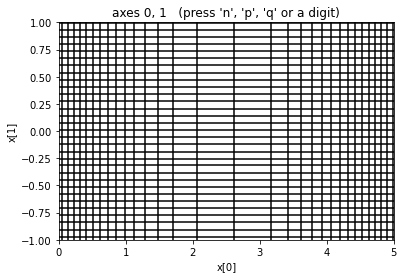

In [205]:
integ.map.show_grid(30)

In [202]:
sigmaS = 5
sigmaA = 3
q = 3
L = 5
W = 3
bias = [.5,.5]

def f(x):
    return mc_vegas(sigmaS, sigmaA, q, L, x[0], x[1], bias)
    
integ = vegas.Integrator([[0, W], [-1,1]])

result = integ(f, nitn=10, neval=10000)
print(result.summary())
print('Total leakage = ', result[0])
print('Left leakage = ', result[1])
print('Right leakage = ', result[2])

print('ratio of leakage Left = ', result[1]/result[0])
print('ratio of leakage Right = ', result[2]/result[0])

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.1326(49)      0.1326(49)          0.00     1.00
  2   0.1239(60)      0.1291(38)          0.42     0.74
  3   0.1206(61)      0.1268(32)          0.44     0.85
  4   0.133(15)       0.1271(31)          0.32     0.97
  5   0.130(11)       0.1273(30)          0.24     1.00
  6   0.1178(56)      0.1252(27)          0.35     0.99
  7   0.1147(32)      0.1209(20)          0.64     0.87
  8   0.1279(90)      0.1213(20)          0.58     0.94
  9   0.1154(33)      0.1197(17)          0.60     0.94
 10   0.134(20)       0.1198(17)          0.55     0.97

Total leakage =  0.1198(17)
Left leakage =  0.1198(17)
Right leakage =  0(0)
ratio of leakage Left =  1.00000000000(17)
ratio of leakage Right =  0(0)


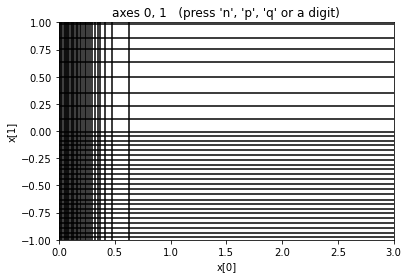

In [203]:
integ.map.show_grid(30)

No left/right bias, source from 0 to 3, highly absorbing

We can see that VEGAS biases the angle as well as the position. So most particles are spawned between 0 and 0.5 with a direction pointing to the left. All angles sampled between (0, 1) are equivalent to a $\mu$ of 1 while all angles pointing in the negative direction produce a $\mu$ of -1. This causes VEGAS to only care about the distinction between positive or negative and not bias any further. 